### FashionMNIST 데이터 세트 다운로드 및 DataLoader 생성

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# DataLoader의 반환값이 Tensor가 되도록 datasets.FashionMNIST 다운로드시 transform인자로 torchvision.transforms의 ToTensor() 적용
train_data = datasets.FashionMNIST(root='data',train= True, download=True, transform=ToTensor())
val_data = datasets.FashionMNIST(root='data',train= False, download=True, transform=ToTensor())

BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4 )
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

images, labels = next(iter(train_loader))
print(images.shape, images.dtype, labels.shape, labels.dtype)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 207kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.8MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



torch.Size([32, 1, 28, 28]) torch.float32 torch.Size([32]) torch.int64


### 네트웍 모델 생성

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.nn.functional as F

class SimpleLinearModel(nn.Module):
    def __init__(self, input_size, num_classes=10):
        super().__init__()
        # nn.Linear는 Layer를 그대로 사용. Linear Layer는 내부적으로 weight, bias등의 learnable parameter 값을 가지고 있기 때문
        # 또한 모델 구성이 좀 더 가득성있고 편리하게 적용 가능. 
        self.linear_01 = nn.Linear(input_size * input_size, 200)
        self.linear_02 = nn.Linear(200, 100)
        self.linear_03 = nn.Linear(100, num_classes)

     # 입력 tensor -> Layer 적용된 출력 tensor -> 다음 Layer에 입력 tensor로 적용 -> ... -> 최종 출력 tensor 반환
    def forward(self, x):
        # nn.Flatten()과 달리 torch.flatten()의 start_dim의 default 값은 0임. batch를 고려하여 flatten되도록 start_dim=1로 설정
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        x = F.relu(self.linear_01(x))
        x = F.relu(self.linear_02(x))
        output = self.linear_03(x)

        # layer들을 통과하면서 적용된 최종 tensor를 반환한다. 
        return output

def create_simple_linear_model(input_size, num_classes=10):
    model = SimpleLinearModel(input_size=input_size, num_classes=num_classes)
    return model
    
INPUT_SIZE = 28
NUM_CLASSES = 10

model = create_simple_linear_model(input_size=INPUT_SIZE, num_classes=NUM_CLASSES)
print(model)

SimpleLinearModel(
  (linear_01): Linear(in_features=784, out_features=200, bias=True)
  (linear_02): Linear(in_features=200, out_features=100, bias=True)
  (linear_03): Linear(in_features=100, out_features=10, bias=True)
)


### Training Loop를 위한 클래스 Trainer 생성 - 기본
* Trainer 클래스는 모델, Loss Function, Optimizer, 학습용 DataLoader, 검증용 DataLoader, device를 생성 인자로 받음. 
* train 수행(train_epoch)과 검증 수행(valid_epoch)을 별도의 메소드로 정의하고 fit(epochs) 메소드에서 epochs 만큼 이들 메소드를 반복적으로 수행. 
* tqdm을 이용하여 배치단위 loss값을 Progress Bar에서 Update하면서 나타냄.
* loss값은 배치 단위 loss이며 running 평균 loss는 표시하지 않음. 

In [3]:
from tqdm import tqdm

class Trainer_01:
    def __init__(self, model, loss_fn, optimizer, train_loader, val_loader, device=None):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
    
    def train_epoch(self, epoch):
        self.model.train()
        # tqdm으로 실시간 training loop 진행 상황 시각화
        with tqdm(total=len(self.train_loader), desc=f"Epoch {epoch+1} [Training..]", leave=True) as progress_bar:
            for batch_idx, (inputs, targets) in enumerate(self.train_loader):
                # 반드시 to(self.device). to(device) 아님. 
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                # Forward pass
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)
                
                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                #tqdm progress_bar에 진행 상황 및 batch loss 값 표시
                progress_bar.update(1)
                if batch_idx % 20 == 0:  # 20 batch횟수마다 update 
                    progress_bar.set_postfix({"Batch Loss": loss.item()})
                if (batch_idx + 1) == len(self.train_loader):
                    progress_bar.set_postfix({"Batch Loss": loss.item()})
                
    def validate_epoch(self, epoch):
        if not self.val_loader:
            return None
            
        self.model.eval()
        
        with tqdm(total=len(self.val_loader), desc=f"Epoch {epoch+1} [Validating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(self.val_loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    
                    outputs = self.model(inputs)
                    
                    loss = self.loss_fn(outputs, targets)

                    progress_bar.update(1)
                    if batch_idx % 20 == 0:  # 20 batch횟수마다 update 
                        progress_bar.set_postfix({"Batch Loss": loss.item()})
                    if (batch_idx + 1) == len(self.train_loader):
                        progress_bar.set_postfix({"Batch Loss": loss.item()})
    
    def fit(self, epochs):
        for epoch in range(epochs):
            self.train_epoch(epoch)
            self.validate_epoch(epoch)

#### Trainer(기본) 수행

In [4]:
from torch.optim import Adam

BATCH_SIZE = 32
INPUT_SIZE = 28

# train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4 )
# val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# model, device, optimizer, loss 함수 생성.
model = create_simple_linear_model(input_size=INPUT_SIZE, num_classes=10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Trainer 객체 생성. 
trainer = Trainer_01(model=model, loss_fn=loss_fn, optimizer=optimizer, train_loader=train_loader,
                 val_loader=val_loader, device=device)

#fit() 을 호출하여 학습과 검증을 epochs 수 만큼 반복 수행. 
trainer.fit(epochs=10)

Epoch 10 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 311.93it/s, Batch Loss=0.224]


### 학습, 검증 Loop 시 running 평균 loss 구하기
* 배치 running 시마다 평균 loss를 progress bar에 표출. 배치 running loss 합을 running 횟수로 나눠서 구함. 

In [5]:
from tqdm import tqdm

class Trainer_02:
    def __init__(self, model, loss_fn, optimizer, train_loader, val_loader, device=None):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
    
    def train_epoch(self, epoch):
        self.model.train()
        # running 평균 loss 계산.
        accu_loss = 0.0
        running_avg_loss = 0.0
        
        # tqdm으로 실시간 training loop 진행 상황 시각화
        with tqdm(total=len(self.train_loader), desc=f"Epoch {epoch+1} [Training..]", leave=True) as progress_bar:
            for batch_idx, (inputs, targets) in enumerate(self.train_loader):
                # 반드시 to(self.device). to(device) 아님.
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                # Forward pass
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)
                
                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # batch 반복 시 마다 누적  loss를 구하고 이를 batch 횟수로 나눠서 running 평균 loss 구함.
                accu_loss += loss.item()
                running_avg_loss = accu_loss / (batch_idx + 1)
                
                #tqdm progress_bar에 진행 상황 및 running 평균 loss 값 표시
                progress_bar.update(1)
                if batch_idx % 20 == 0: # 20 batch 횟수마다 update
                    progress_bar.set_postfix({"Loss": running_avg_loss})
                
        # 최종 running 평균 loss 반환     
        return running_avg_loss
                
    def validate_epoch(self, epoch):
        if not self.val_loader:
            return None
            
        self.model.eval()

        # running 평균 loss 계산. 
        accu_loss = 0
        running_avg_loss = 0
        
        with tqdm(total=len(self.val_loader), desc=f"Epoch {epoch+1} [Validating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(self.val_loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    
                    outputs = self.model(inputs)
                    
                    loss = self.loss_fn(outputs, targets)
                    # batch 반복 시 마다 누적  loss를 구하고 이를 batch 횟수로 나눠서 running 평균 loss 구함.  
                    accu_loss += loss.item()
                    running_avg_loss = accu_loss /(batch_idx + 1)
                    
                    #tqdm progress_bar에 진행 상황 및 running 평균 loss 값 표시
                    progress_bar.update(1)
                    if batch_idx % 20 == 0:  # 20 batch횟수마다 update 
                        progress_bar.set_postfix({"Loss": running_avg_loss})
        
        # 최종 running 평균 loss 반환     
        return running_avg_loss
    
    def fit(self, epochs):
        for epoch in range(epochs):
            train_loss = self.train_epoch(epoch)
            val_loss = self.validate_epoch(epoch)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}", 
                  f", Val Loss: {val_loss:.4f}" if val_loss is not None else "")

In [6]:
from torch.optim import Adam

# 기존 학습된 model, optimizer를 재 사용하지 않고 새로운 model, optimizer생성.
model = create_simple_linear_model(input_size=INPUT_SIZE, num_classes=10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer_02(model=model, loss_fn=loss_fn, optimizer=optimizer, train_loader=train_loader,
                 val_loader=val_loader, device=device)

#fit() 을 호출하여 학습과 검증을 epochs 수 만큼 반복 수행. 
trainer.fit(epochs=10)

Epoch 1 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 349.07it/s, Loss=0.439]


Epoch 1/10, Train Loss: 0.4990 , Val Loss: 0.4380


Epoch 2 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 343.41it/s, Loss=0.387]


Epoch 2/10, Train Loss: 0.3657 , Val Loss: 0.3851


Epoch 3 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 357.11it/s, Loss=0.408]


Epoch 3/10, Train Loss: 0.3274 , Val Loss: 0.4060


Epoch 4 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 354.00it/s, Loss=0.371]


Epoch 4/10, Train Loss: 0.3040 , Val Loss: 0.3679


Epoch 5 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 356.79it/s, Loss=0.337]


Epoch 5/10, Train Loss: 0.2873 , Val Loss: 0.3354


Epoch 6 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 319.26it/s, Loss=0.343]


Epoch 6/10, Train Loss: 0.2704 , Val Loss: 0.3419


Epoch 7 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 333.94it/s, Loss=0.342]


Epoch 7/10, Train Loss: 0.2614 , Val Loss: 0.3390


Epoch 8 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 338.85it/s, Loss=0.33] 


Epoch 8/10, Train Loss: 0.2462 , Val Loss: 0.3280


Epoch 9 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 350.02it/s, Loss=0.32] 


Epoch 9/10, Train Loss: 0.2384 , Val Loss: 0.3171


Epoch 10 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 339.78it/s, Loss=0.323]

Epoch 10/10, Train Loss: 0.2277 , Val Loss: 0.3217


### Training Loop에서 정확도 Metric 값 구하기
* 학습/검증 데이터에서 loss값과 함께 정확도를 running 평균으로 구함
* 배치별로 누적된 전체 데이터  건수와 예측이 맞은 누적 건수로 accuracy 계산
* 예측 클래스 값을 위해 softmax를 반드시 적용할 필요 없음. 가장 높은 logit 값이 가장 높은 softmax값이므로 softmax 변환없이 argmax()를 적용하여 예측 클래스값 생성 가능

In [20]:
# 학습 데이터에서 image와 labels을 batch size 만큼 추출 
images, labels = next(iter(train_loader))

model = model.to('cpu')
# 모델에 images 데이터 입력 후 출력. 출력값은 (batch_size, num_classes) shape
pred = model(images)
# print('pred:', pred)
print('pred shape:', pred.shape)


# 모델 출력의 argmax()와 softmax()를 적용한 결과의 argmax()가 모두 동일. 
print('pred argmax_01:', pred.argmax(-1))
print('pred argmax_02:', F.softmax(pred, dim=-1).argmax(-1))

# argmax 가 아니라 max()를 적용. tensor.max()의 반환은 max 값과 max값이 위치한 tensor index를 함께 반환함. 
max_value, max_index = pred.max(-1)
print('max_value:', max_value)
print('max_index:', max_index)

pred shape: torch.Size([32, 10])
pred argmax_01: tensor([3, 6, 3, 2, 3, 3, 5, 8, 5, 5, 8, 0, 8, 5, 4, 9, 8, 9, 4, 3, 6, 8, 5, 3,
        5, 3, 8, 4, 7, 0, 0, 5])
pred argmax_02: tensor([3, 6, 3, 2, 3, 3, 5, 8, 5, 5, 8, 0, 8, 5, 4, 9, 8, 9, 4, 3, 6, 8, 5, 3,
        5, 3, 8, 4, 7, 0, 0, 5])
max_value: tensor([ 5.9861,  4.4020,  3.4459, 10.3790,  2.3068,  4.6750, 15.7322, 23.9899,
        11.7536, 24.6619, 24.3600,  3.8912,  7.9629, 17.7620,  5.0843, 13.0726,
        20.2279, 15.8301,  4.0569,  6.6089,  5.6841, 22.3477, 19.8609,  6.2045,
        19.4014,  3.0296, 14.1371,  2.6664,  6.6874, -0.1099,  5.9486,  4.1913],
       grad_fn=<MaxBackward0>)
max_index: tensor([3, 6, 3, 2, 3, 3, 5, 8, 5, 5, 8, 0, 8, 5, 4, 9, 8, 9, 4, 3, 6, 8, 5, 3,
        5, 3, 8, 4, 7, 0, 0, 5])


In [23]:
from tqdm import tqdm
import torch.nn.functional as F

class Trainer:
    def __init__(self, model, loss_fn, optimizer, train_loader, val_loader, device=None):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
    
    def train_epoch(self, epoch):
        self.model.train()
        
        # running 평균 loss 계산. 
        accu_loss = 0.0
        running_avg_loss = 0.0
        # 정확도, 정확도 계산을 위한 전체 건수 및 누적 정확건수
        num_total = 0.0
        accu_num_correct = 0.0
        accuracy = 0.0
        
        # tqdm으로 실시간 training loop 진행 상황 시각화
        with tqdm(total=len(self.train_loader), desc=f"Epoch {epoch+1} [Training..]", leave=True) as progress_bar:
            for batch_idx, (inputs, targets) in enumerate(self.train_loader):
                # 반드시 to(self.device). to(device) 아님. 
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                # Forward pass
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)
                
                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # batch 반복 시 마다 누적  loss를 구하고 이를 batch 횟수로 나눠서 running 평균 loss 구함.  
                accu_loss += loss.item()
                running_avg_loss = accu_loss /(batch_idx + 1)

                # accuracy metric 계산
                # outputs 출력 예측 class값과 targets값 일치 건수 구하고
                num_correct = (outputs.argmax(-1) == targets).sum().item()
                # 배치별 누적 전체 건수와 누적 전체 num_correct 건수로 accuracy 계산
                num_total += inputs.shape[0]
                accu_num_correct += num_correct
                accuracy = accu_num_correct / num_total

                #tqdm progress_bar에 진행 상황 및 running 평균 loss와 정확도 표시
                progress_bar.update(1)
                if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:  # 20 batch횟수마다 또는 맨 마지막 batch에서 update 
                    progress_bar.set_postfix({"Loss": running_avg_loss, 
                                              "Accuracy": accuracy})
        
        return running_avg_loss, accuracy
                
    def validate_epoch(self, epoch):
        if not self.val_loader:
            return None
            
        self.model.eval()

        # running 평균 loss 계산. 
        accu_loss = 0
        running_avg_loss = 0
        # 정확도, 정확도 계산을 위한 전체 건수 및 누적 정확건수
        num_total = 0.0
        accu_num_correct = 0.0
        accuracy = 0.0
        with tqdm(total=len(self.val_loader), desc=f"Epoch {epoch+1} [Validating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(self.val_loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    
                    outputs = self.model(inputs)
                    
                    loss = self.loss_fn(outputs, targets)
                    # batch 반복 시 마다 누적  loss를 구하고 이를 batch 횟수로 나눠서 running 평균 loss 구함.  
                    accu_loss += loss.item()
                    running_avg_loss = accu_loss /(batch_idx + 1)

                    # accuracy metric 계산
                    # outputs 출력 예측 class값과 targets값 일치 건수 구하고
                    num_correct = (outputs.argmax(-1) == targets).sum().item()
                    # 배치별 누적 전체 건수와 누적 전체 num_correct 건수로 accuracy 계산  
                    num_total += inputs.shape[0]
                    accu_num_correct += num_correct
                    accuracy = accu_num_correct / num_total

                    #tqdm progress_bar에 진행 상황 및 running 평균 loss와 정확도 표시
                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:  # 20 batch횟수마다 또는 맨 마지막 batch에서 update 
                        progress_bar.set_postfix({"Loss": running_avg_loss, 
                                                  "Accuracy":accuracy})
        return running_avg_loss, accuracy
    
    def fit(self, epochs):
        # epoch 시마다 학습/검증 결과를 기록하는 history dict 생성.
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate_epoch(epoch)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}",
                  f", Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}" if val_loss is not None else "")
            # epoch 시마다 학습/검증 결과를 기록.
            history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
            
        return history 
    
    # 학습이 완료된 모델을 return 
    def get_trained_model(self):
        return self.model

In [25]:
from torch.optim import Adam

model = create_simple_linear_model(input_size=INPUT_SIZE, num_classes=10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer, train_loader=train_loader,
                 val_loader=val_loader, device=device)

# 이번에는 20회로 늘려서 학습 및 평가. 오버피팅 체크
history = trainer.fit(20)

Epoch 1 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 272.99it/s, Loss=0.409, Accuracy=0.853]


Epoch 1/20, Train Loss: 0.5027 Train Accuracy: 0.8187 , Val Loss: 0.4091 Val Accuracy: 0.8531


Epoch 2 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 347.16it/s, Loss=0.396, Accuracy=0.862]


Epoch 2/20, Train Loss: 0.3643 Train Accuracy: 0.8655 , Val Loss: 0.3963 Val Accuracy: 0.8619


Epoch 3 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 349.17it/s, Loss=0.358, Accuracy=0.871]


Epoch 3/20, Train Loss: 0.3283 Train Accuracy: 0.8788 , Val Loss: 0.3584 Val Accuracy: 0.8710


Epoch 4 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 354.42it/s, Loss=0.383, Accuracy=0.862]


Epoch 4/20, Train Loss: 0.3051 Train Accuracy: 0.8867 , Val Loss: 0.3826 Val Accuracy: 0.8623


Epoch 5 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 338.05it/s, Loss=0.347, Accuracy=0.876]


Epoch 5/20, Train Loss: 0.2867 Train Accuracy: 0.8927 , Val Loss: 0.3475 Val Accuracy: 0.8761


Epoch 6 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 347.56it/s, Loss=0.346, Accuracy=0.878]


Epoch 6/20, Train Loss: 0.2729 Train Accuracy: 0.8979 , Val Loss: 0.3459 Val Accuracy: 0.8785


Epoch 7 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 355.87it/s, Loss=0.329, Accuracy=0.883]


Epoch 7/20, Train Loss: 0.2591 Train Accuracy: 0.9024 , Val Loss: 0.3285 Val Accuracy: 0.8835


Epoch 8 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 348.67it/s, Loss=0.339, Accuracy=0.884]


Epoch 8/20, Train Loss: 0.2478 Train Accuracy: 0.9051 , Val Loss: 0.3391 Val Accuracy: 0.8836


Epoch 9 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 345.27it/s, Loss=0.326, Accuracy=0.887]


Epoch 9/20, Train Loss: 0.2364 Train Accuracy: 0.9111 , Val Loss: 0.3262 Val Accuracy: 0.8875


Epoch 10 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 348.69it/s, Loss=0.336, Accuracy=0.889]


Epoch 10/20, Train Loss: 0.2261 Train Accuracy: 0.9140 , Val Loss: 0.3360 Val Accuracy: 0.8888


Epoch 11 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 353.49it/s, Loss=0.341, Accuracy=0.885]


Epoch 11/20, Train Loss: 0.2189 Train Accuracy: 0.9167 , Val Loss: 0.3414 Val Accuracy: 0.8855


Epoch 12 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 356.19it/s, Loss=0.341, Accuracy=0.888]


Epoch 12/20, Train Loss: 0.2126 Train Accuracy: 0.9176 , Val Loss: 0.3411 Val Accuracy: 0.8880


Epoch 13 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 349.12it/s, Loss=0.356, Accuracy=0.885]


Epoch 13/20, Train Loss: 0.2038 Train Accuracy: 0.9225 , Val Loss: 0.3557 Val Accuracy: 0.8849


Epoch 14 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 352.48it/s, Loss=0.336, Accuracy=0.889]


Epoch 14/20, Train Loss: 0.1983 Train Accuracy: 0.9244 , Val Loss: 0.3362 Val Accuracy: 0.8893


Epoch 15 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 348.94it/s, Loss=0.349, Accuracy=0.89] 


Epoch 15/20, Train Loss: 0.1902 Train Accuracy: 0.9282 , Val Loss: 0.3485 Val Accuracy: 0.8903


Epoch 16 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 356.75it/s, Loss=0.352, Accuracy=0.891]


Epoch 16/20, Train Loss: 0.1843 Train Accuracy: 0.9293 , Val Loss: 0.3525 Val Accuracy: 0.8909


Epoch 17 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 348.71it/s, Loss=0.384, Accuracy=0.883]


Epoch 17/20, Train Loss: 0.1789 Train Accuracy: 0.9316 , Val Loss: 0.3844 Val Accuracy: 0.8826


Epoch 18 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 335.71it/s, Loss=0.37, Accuracy=0.89]  


Epoch 18/20, Train Loss: 0.1739 Train Accuracy: 0.9334 , Val Loss: 0.3703 Val Accuracy: 0.8902


Epoch 19 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 351.82it/s, Loss=0.373, Accuracy=0.89] 


Epoch 19/20, Train Loss: 0.1664 Train Accuracy: 0.9355 , Val Loss: 0.3731 Val Accuracy: 0.8897


Epoch 20 [Validating]: 100%|██████████| 313/313 [00:00<00:00, 337.45it/s, Loss=0.382, Accuracy=0.892]

Epoch 20/20, Train Loss: 0.1647 Train Accuracy: 0.9363 , Val Loss: 0.3818 Val Accuracy: 0.8916


### Epoch별로 학습/검증 Loss와 Accuracy 시각화
* trainer.fit() 수행 후 반환된 history dict를 기반으로 시각화 수행. 

In [27]:
history

{'train_loss': [0.5026721840818723,
  0.3643207260886828,
  0.3282847548186779,
  0.30510423103173573,
  0.286744550160567,
  0.2728878898183505,
  0.2590917838588357,
  0.24781576030403377,
  0.23640501061677932,
  0.2261437296365698,
  0.21891507300436497,
  0.2126195686971148,
  0.20380015892088413,
  0.198308367434144,
  0.1901818752800425,
  0.1842992175300916,
  0.17890355142106612,
  0.17390796484251816,
  0.16640319842298826,
  0.16467721591020623],
 'train_acc': [0.81875,
  0.8654833333333334,
  0.87875,
  0.8866833333333334,
  0.8927166666666667,
  0.8979333333333334,
  0.9024333333333333,
  0.9051,
  0.9111166666666667,
  0.9140166666666667,
  0.9166833333333333,
  0.9175833333333333,
  0.9225166666666667,
  0.92445,
  0.9282333333333334,
  0.9293333333333333,
  0.93165,
  0.93335,
  0.9355333333333333,
  0.9362666666666667],
 'val_loss': [0.40909730819181894,
  0.3962983870372985,
  0.3583922129564773,
  0.3825618116714703,
  0.34749493944330717,
  0.34590531051301726,
  0.

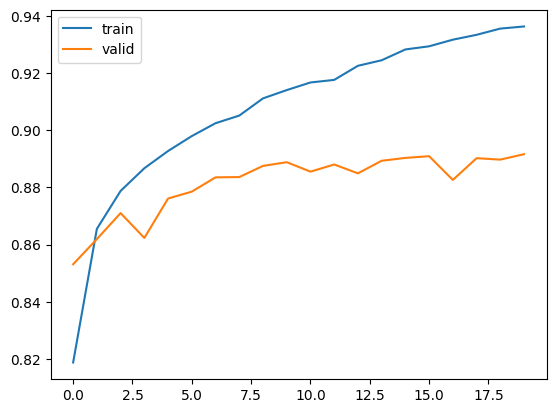

In [ ]:
import matplotlib.pyplot as plt

def show_history(history, metric='acc'):
    if metric == 'loss':
        train_metric_name = 'train_loss'
        val_metric_name = 'val_loss'
    else:
        train_metric_name = 'train_acc'
        val_metric_name = 'val_acc'
        
    plt.plot(history[train_metric_name], label='train')
    plt.plot(history[val_metric_name], label='valid')
    plt.legend()
    
show_history(history, metric='acc')

### Predictor 클래스 생성
* 입력 데이터는 tensor가 되어야 하며, 학습 데이터와 동일한 정규화 값을 적용. 
* evaluate(), predict_proba(), predict() 메소드 생성
* evaluate()는 테스트 이미지 Tensor 데이터 전체를 대상으로 성능 평가 수행
* predict_proba()는 입력 이미지 Tensor들(단일 이미지 Tensor 포함)의 클래스별 예측 확률 계산
* predict()는 입력 이미지 Tensor들(단일 이미지 Tensor 포함)의 클래스값 예측

In [35]:
class Predictor:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device

    def evaluate(self, loader):
        self.model.eval()
        eval_metric = 0.0
        # 정확도 계산을 위한 전체 건수 및 누적 정확건수
        num_total = 0.0
        accu_num_correct = 0.0

        with tqdm(total=len(loader), desc=f"[Evaluating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    pred = self.model(inputs)

                    # 정확도 계산을 위해 누적 전체 건수와 누적 전체 num_correct 건수 계산  
                    num_correct = (pred.argmax(-1) == targets).sum().item()
                    num_total += inputs.shape[0]
                    accu_num_correct += num_correct
                    eval_metric = accu_num_correct / num_total

                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:
                        progress_bar.set_postfix({"Accuracy": eval_metric})
        
        return eval_metric

    def predict_proba(self, inputs):
        self.model.eval()
        with torch.no_grad():
            inputs = inputs.to(self.device)
            outputs = self.model(inputs)
            #예측값을 반환하므로 targets은 필요 없음.
            #targets = targets.to(self.device)
            pred_proba = F.softmax(outputs, dim=-1) #또는 dim=1

        return pred_proba

    def predict(self, inputs):
        pred_proba = self.predict_proba(inputs)
        pred_class = torch.argmax(pred_proba, dim=-1)

        return pred_class

In [36]:
trained_model = trainer.get_trained_model()

BATCH_SIZE = 32
# 학습데이터와 동일하게 정규화된 데이터를 입력해야 함.
test_data = datasets.FashionMNIST(root='data',train= False, download=True, transform=ToTensor())
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

predictor = Predictor(model=trained_model, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')

[Evaluating]: 100%|██████████| 313/313 [00:00<00:00, 344.65it/s, Accuracy=0.892]

test dataset evaluation:0.8916


In [39]:
images, labels = next(iter(test_loader))
print(images.shape)
preds = predictor.predict(images)
print('predicted:', preds,'\n실제 labels:', labels)

torch.Size([32, 1, 28, 28])
predicted: tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 2, 8, 0, 2, 5, 7, 5,
        1, 2, 6, 0, 9, 3, 8, 8], device='cuda:0') 
실제 labels: tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8])


In [44]:
pred_probas = predictor.predict_proba(images)
print(pred_probas)

tensor([[4.2739e-09, 6.8505e-15, 4.8932e-10, 1.5091e-12, 2.8117e-14, 7.4869e-09,
         9.6141e-10, 1.7055e-06, 4.4114e-11, 1.0000e+00],
        [3.8866e-06, 1.4720e-16, 9.9683e-01, 5.0634e-16, 3.0961e-03, 5.4526e-22,
         6.9100e-05, 3.7376e-24, 5.0554e-18, 5.5615e-20],
        [7.3731e-18, 1.0000e+00, 3.8108e-20, 4.7317e-20, 3.2528e-18, 0.0000e+00,
         1.1506e-19, 1.6255e-43, 4.9211e-25, 0.0000e+00],
        [1.6099e-14, 1.0000e+00, 1.1875e-18, 1.5684e-14, 1.9662e-14, 4.2128e-29,
         3.9099e-14, 3.1408e-30, 1.8178e-18, 1.0811e-30],
        [2.8815e-03, 3.2567e-16, 1.3231e-05, 1.9945e-08, 4.4288e-06, 9.0539e-12,
         9.9710e-01, 5.2360e-16, 2.0802e-09, 8.2570e-13],
        [1.2079e-11, 1.0000e+00, 3.4778e-13, 7.0379e-16, 2.0408e-13, 9.9039e-37,
         3.3445e-14, 7.7544e-35, 6.8685e-19, 2.8464e-37],
        [4.4202e-18, 2.3102e-17, 5.0862e-08, 4.4495e-13, 1.0000e+00, 4.6181e-35,
         6.5769e-10, 4.3563e-29, 2.7008e-23, 9.3343e-33],
        [9.3249e-14, 4.0249

#### 단일 이미지 판별하기
* PIL 또는 Numpy arrary 단일 이미지로 입력되면 이를 tensor로 변환해서 predict()에 입력해 줘야 함. 

In [46]:
# ToTensor()없이 test_data 설정
test_data_pil = datasets.FashionMNIST(root='data',train= False, download=True)
test_data_pil[0]

(<PIL.Image.Image image mode=L size=28x28>, 9)

Text(0.5, 1.0, 'Ankle boot: 9')

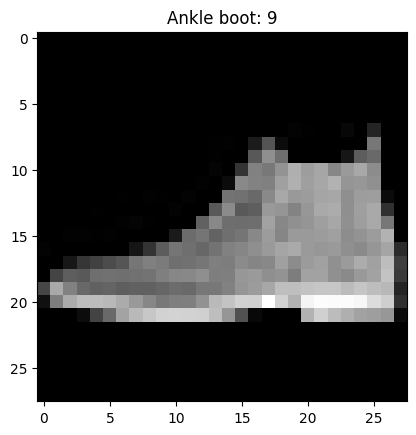

In [47]:
import matplotlib.pyplot as plt

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.imshow(test_data_pil[0][0], cmap='gray')
plt.title(f'{class_names[test_data_pil[0][1]]}: {test_data_pil[0][1]}')

In [48]:
from torchvision.transforms import ToTensor

# PIL 이미지를 Tensor로 변환. 
transform = ToTensor()
input_tensor = transform(test_data_pil[0][0])
print(type(input_tensor), input_tensor.shape)

<class 'torch.Tensor'> torch.Size([1, 28, 28])


In [49]:
input_tensor.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [53]:
# 입력 이미지는 4차원으로 변환해서 넣어 줄 것
print(input_tensor.unsqueeze(0).shape)
pred = predictor.predict(input_tensor.unsqueeze(0))
print(pred.cpu().numpy())

torch.Size([1, 1, 28, 28])
[9]


### 모델의 저장과 로드
* 모델 구조와 파라미터들을 함께 저장/로드하는 방법과 파라미터만 저장/로드하는 방법이 있음.
* 전체를 다 저장/로드 
    * 학습이 수행된 모델(메모리에 있는 모델)은 torch.save(모델, 저장위치)로 파일로 저장할 수 있음
    * 파일로 저장된 모델은 torch.load(저장위치)로 다시 메모리로 로딩 될 수 있음
* 파라미터만 저장/로드
    * torch.save(model.state_dict(), 저장위치)와 같이 model의 state_dict() 메소드를 호출하여 파라미터만 파일로 저장
    * 파라미터가 학습되지 않은 최초 모델을 생성 후 model.load_state_dict()로 저장된 파라미터를 로딩
* 전체 구조를 저장/로드하는 것 보다는 파라미터만 저장/로드 하는것을 권장. pytorch 버전이 다를 경우 동작이 안될 가능성이 있음 또한, 파일 사이즈도 상대적으로 작으며, 기존 모델에서 layer를 추가하여 새로운 모델을 만들더라도 기존 파라미터를 적용할 수 있음

In [58]:
trained_model = trainer.get_trained_model()

checkpoint_filepath_01 = '/kaggle/working/checkpoint_01.pt'
# model 전체를 저장하기. 
torch.save(trained_model, checkpoint_filepath_01)

In [60]:
restored_model_01 = torch.load(checkpoint_filepath_01, weights_only=False)

In [61]:
BATCH_SIZE = 32
# 학습데이터와 동일하게 정규화된 데이터를 입력해야 함.
test_data = datasets.FashionMNIST(root='data',train= False, download=True, transform=ToTensor())
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# checkpoint로 로딩된 모델을 이용하여 성능 평가. 
predictor = Predictor(model=restored_model_01, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')

[Evaluating]: 100%|██████████| 313/313 [00:00<00:00, 346.48it/s, Accuracy=0.892]

test dataset evaluation:0.8916


In [63]:
checkpoint_filepath_02 = '/kaggle/working/checkpoint_02.pt'
# 파라미터만 저장하기. 
torch.save(trained_model.state_dict(), checkpoint_filepath_02)

In [65]:
# checkpoint 파일에서 파라미터만 추출. 
state_dict = torch.load(checkpoint_filepath_02, weights_only=True)

# Weight가 학습 되지 않은 초기 모델 생성.
restored_model_02 =  create_simple_linear_model(input_size=28, num_classes=10)

# 신규 모델에 파라미터 로딩
restored_model_02.load_state_dict(state_dict)

#restored_model_02.eval()

<All keys matched successfully>

In [66]:
BATCH_SIZE = 32
# 학습데이터와 동일하게 정규화된 데이터를 입력해야 함.
test_data = datasets.FashionMNIST(root='data',train= False, download=True, transform=ToTensor())
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# checkpoint로 로딩된 모델을 이용하여 성능 평가. 
predictor = Predictor(model=restored_model_02, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')

[Evaluating]: 100%|██████████| 313/313 [00:00<00:00, 334.67it/s, Accuracy=0.892]

test dataset evaluation:0.8916
